# Importing the relevant libraries

In [1]:
# Importing the Pandas library for data manipulation and analysis
import pandas as pd


# Data Preprocessing

### Importing the Database

In [2]:
# Load the data from a CSV file into a Pandas DataFrame
raw_data = pd.read_csv('ml_datasource.csv')

# Create a copy of the data to ensure the original data remains unchanged during manipulations
data = raw_data.copy()

# Display the first 5 rows of the dataset for a quick preview
data.head(5)


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


### Removing Outliers

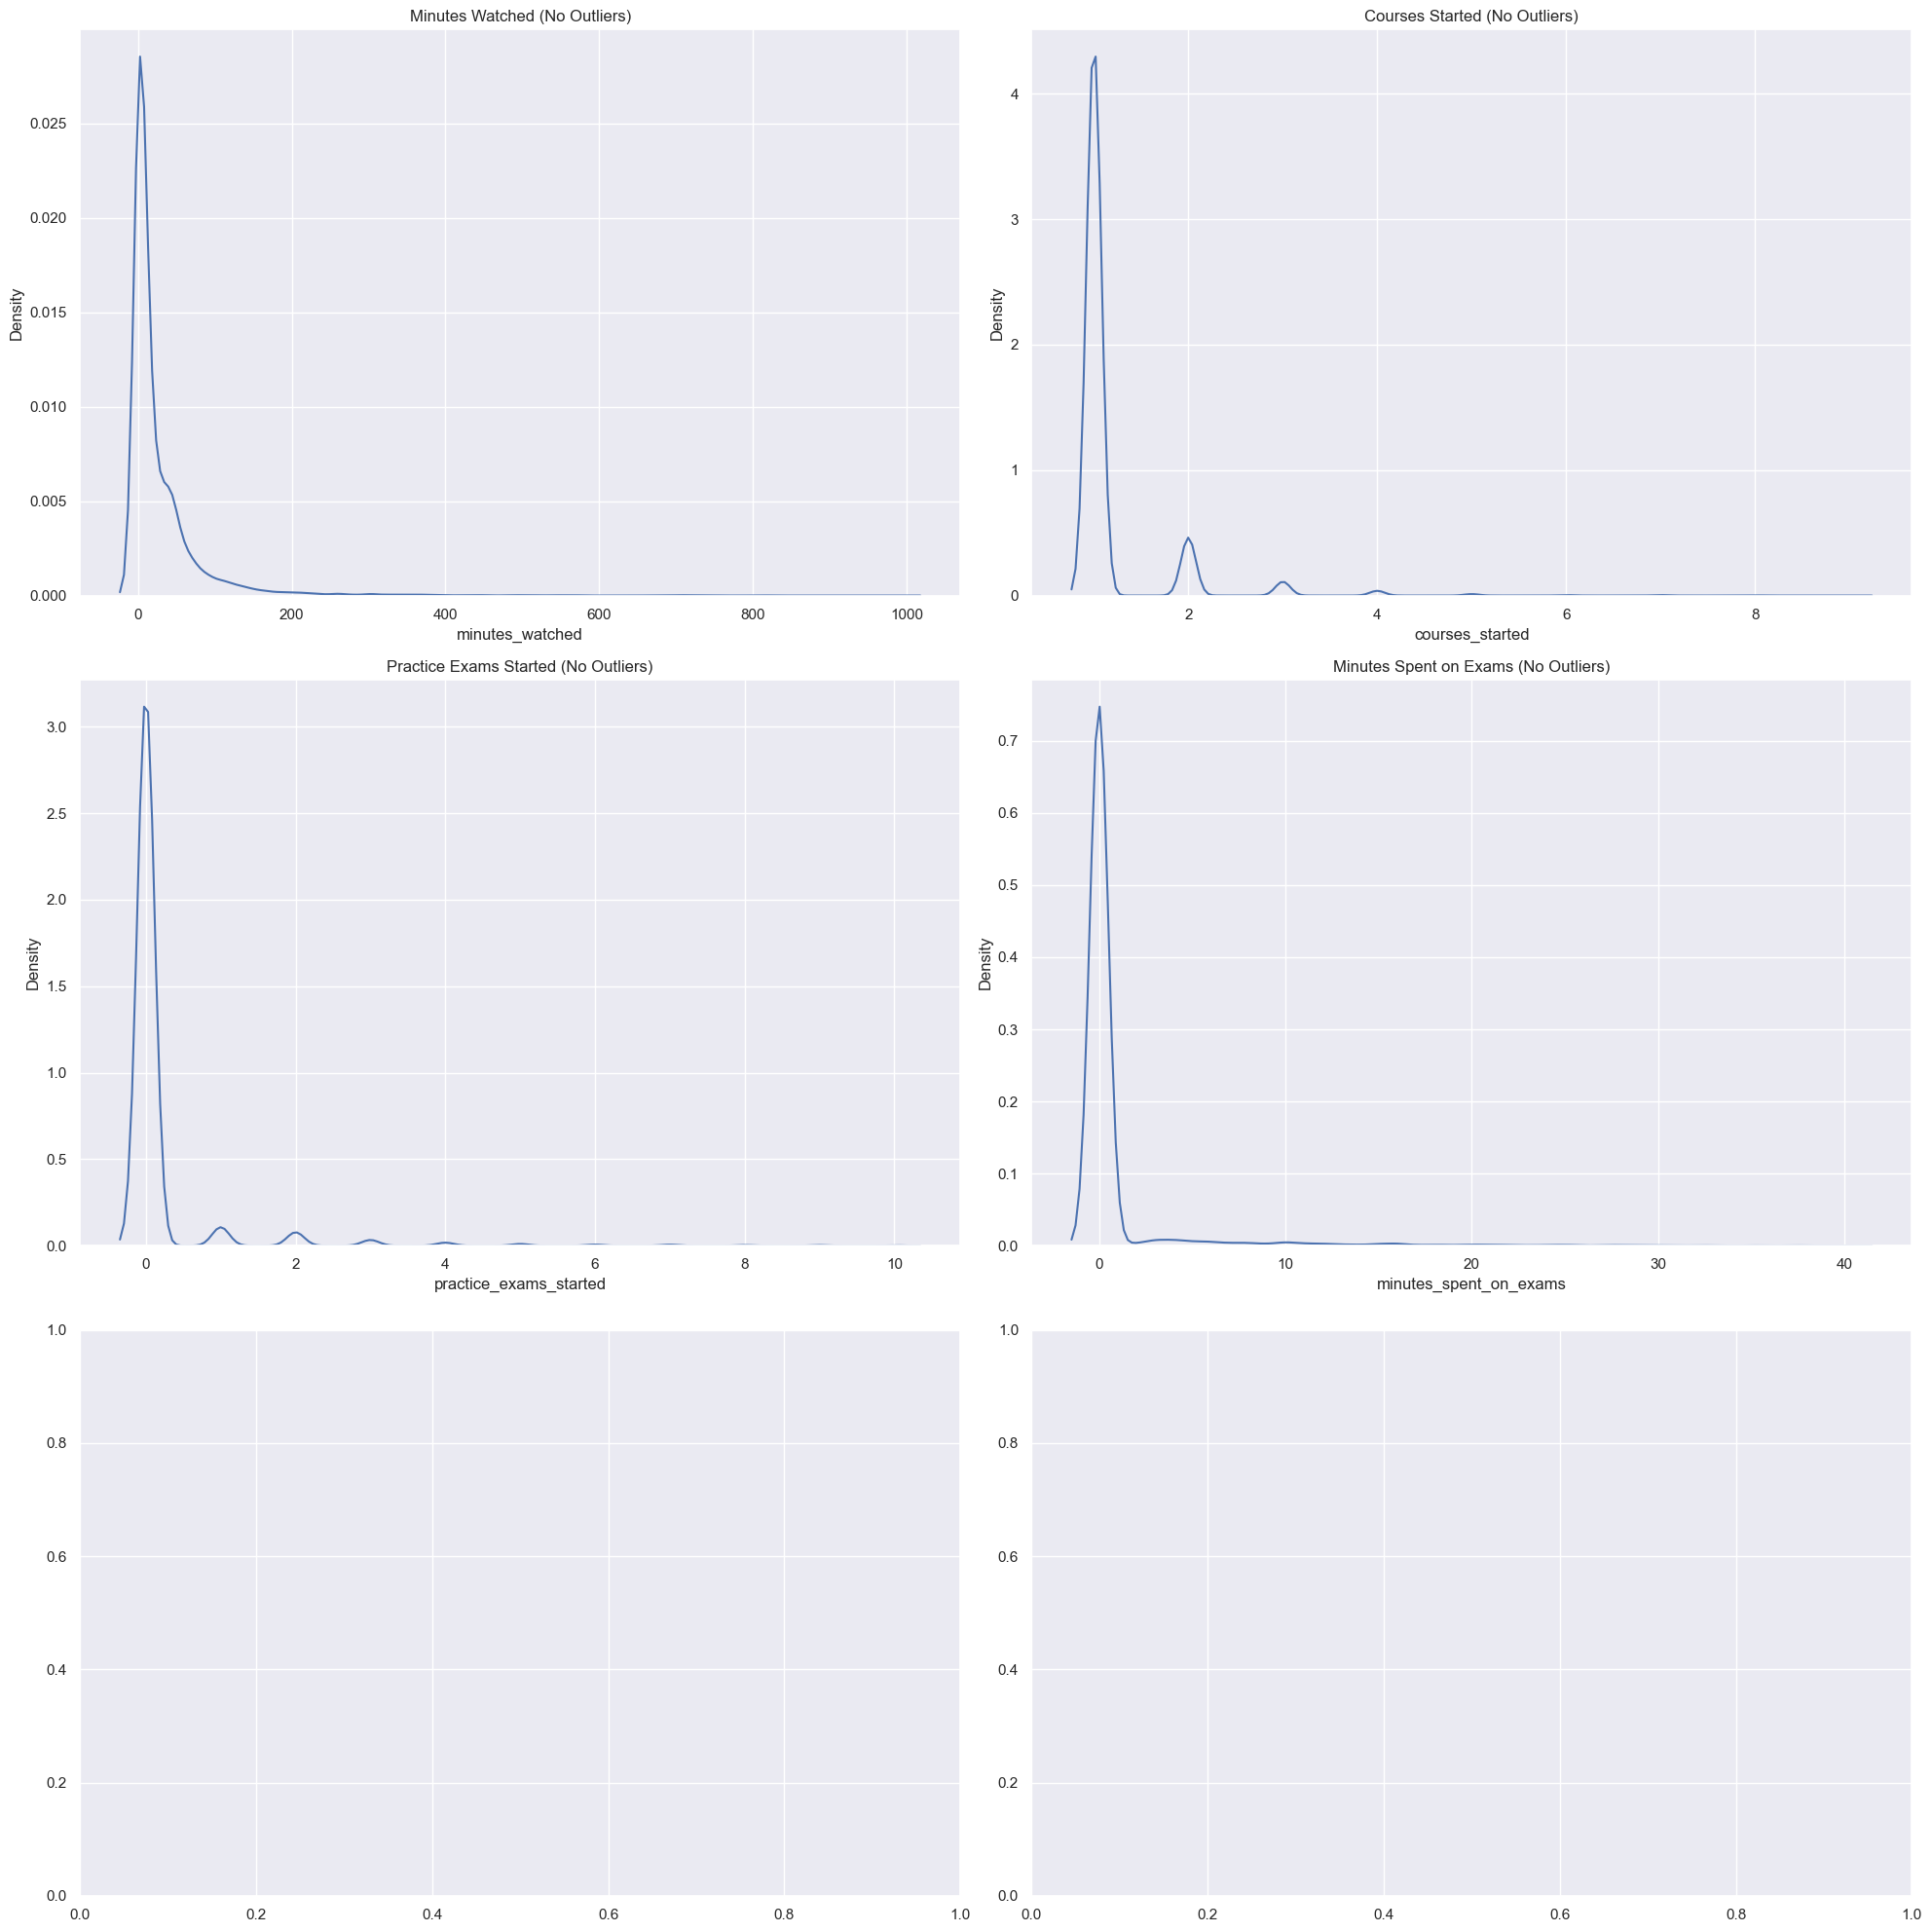

Original dataset size: 17761
Dataset size after removing outliers: 17626


In [5]:
# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn's style for improved plot aesthetics
sns.set()

# Removing outliers based on specified thresholds
data_no_outliers = data[
    (data['minutes_watched'] <= 1000) &
    (data['courses_started'] <= 10) &
    (data['practice_exams_started'] <= 10) &
    (data['minutes_spent_on_exams'] <= 40)
]

# Visualize data distributions again without outliers
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
sns.kdeplot(data_no_outliers['minutes_watched'], ax=axes[0, 0]).set(title='Minutes Watched (No Outliers)')
sns.kdeplot(data_no_outliers['courses_started'], ax=axes[0, 1]).set(title='Courses Started (No Outliers)')
sns.kdeplot(data_no_outliers['practice_exams_started'], ax=axes[1, 0]).set(title='Practice Exams Started (No Outliers)')
sns.kdeplot(data_no_outliers['minutes_spent_on_exams'], ax=axes[1, 1]).set(title='Minutes Spent on Exams (No Outliers)')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Displaying the number of rows in the dataset before and after outlier removal
print("Original dataset size:", data.shape[0])
print("Dataset size after removing outliers:", data_no_outliers.shape[0])


### Checking for Multicollinearity

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Define a function to calculate Variance Inflation Factor (VIF), which indicates multicollinearity among features
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF for the numerical columns in the dataset
numerical_cols = data_no_outliers.select_dtypes(include=['float64', 'int64'])
vif = calculate_vif(numerical_cols)

# Iteratively remove columns with a high VIF (> 5) to reduce multicollinearity
while vif['VIF'].max() > 5:
    column_to_drop = vif.loc[vif['VIF'].idxmax(), 'Feature']
    numerical_cols = numerical_cols.drop(columns=[column_to_drop])
    vif = calculate_vif(numerical_cols)

# Update dataset with reduced multicollinearity
data_no_mult = data_no_outliers[numerical_cols.columns]


### Dealing with NaN Values

In [7]:
# Check for missing values in the dataset
missing_values = data_no_mult.isnull().sum()

# Display columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

# Strategy for handling missing values:
# - Drop columns with too many missing values, if applicable.
# - Fill missing values using median (numerical) or mode (categorical).

# Fill missing values in numerical columns with the median
numerical_cols_with_nan = data_no_mult.select_dtypes(include=['float64', 'int64']).columns
data_filled = data_no_mult.copy()
for col in numerical_cols_with_nan:
    if data_filled[col].isnull().sum() > 0:
        data_filled[col].fillna(data_filled[col].median(), inplace=True)

# Fill missing values in categorical columns with the mode
categorical_cols_with_nan = data_no_mult.select_dtypes(include=['object']).columns
for col in categorical_cols_with_nan:
    if data_filled[col].isnull().sum() > 0:
        data_filled[col].fillna(data_filled[col].mode()[0], inplace=True)

# Verify no missing values remain
print("Remaining missing values after filling:")
print(data_filled.isnull().sum().sum())

# Final cleaned dataset
data_clean = data_filled.copy()


Columns with missing values:
Series([], dtype: int64)
Remaining missing values after filling:
0


### Splitting the Data

In [8]:
from sklearn.model_selection import train_test_split

# Separate the target variable 'purchased' and the features
X = data_clean.drop(columns=['purchased'])  # 'purchased' is the target variable
y = data_clean['purchased']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (14100, 5)
Test set size: (3526, 5)


### Encoding the Data

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Separate categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Define a preprocessor for encoding and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical features
    ]
)

# Transform the training and testing data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Transformed training data shape:", X_train_transformed.shape)
print("Transformed test data shape:", X_test_transformed.shape)


Transformed training data shape: (14100, 5)
Transformed test data shape: (3526, 5)


# Creating Models
K-Nearest Neighbors Model
Support Vector Machines Model
Decision Trees Model
Random Forests Model

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# List of models to train
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\\nTraining and evaluating: {model_name}")
    model.fit(X_train_transformed, y_train)  # Train the model
    y_pred = model.predict(X_test_transformed)  # Predict on the test set
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")  # Print accuracy
    print(classification_report(y_test, y_pred))  # Print detailed report


\nTraining and evaluating: Logistic Regression
Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3202
           1       0.89      0.46      0.60       324

    accuracy                           0.94      3526
   macro avg       0.92      0.73      0.79      3526
weighted avg       0.94      0.94      0.94      3526

\nTraining and evaluating: K-Nearest Neighbors
Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3202
           1       0.81      0.70      0.75       324

    accuracy                           0.96      3526
   macro avg       0.89      0.84      0.86      3526
weighted avg       0.96      0.96      0.96      3526

\nTraining and evaluating: Support Vector Machine
Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3202
           1       0.79      0.53      0.64     